<h1 style="text-align: center; "><strong>Model Building, Training, Evaluation, and Validation</strong></h1>

### ***Tools*** <a class="anchor"  id="chapter4"></a>

#### ***Framework Selection*** <a class="anchor"  id="chapter4_1"></a>


- **Model Development**: Keras is used as a high-level interface for building, customizing, and training artificial neural network models. Keras provides an easy-to-use and intuitive API, which allows developers to quickly define model architecture, add layers, and configure model training.
- **Pre-trained Models**: In this project, a pre-trained VGG16, VGG19, ResNet50 model architecture are used. Keras provides various pre-trained models that have been trained on large datasets such as ImageNet. This allows developers to easily use a robust and proven model architecture, and utilize features that have been learned from large datasets.
- **Model Training**: TensorFlow acts as a computational backend for Keras. When Keras models are compiled and trained, TensorFlow manages the computations corresponding to the model definition, performs training by updating weights and biases through optimization algorithms such as Adam, and calculates evaluation metrics such as loss and accuracy.
- **Prediction and Evaluation**: Once the model is trained, Keras is used to make predictions on test images. Then, TensorFlow performs the computations required to process the input, run the model, and generate the predicted output. Furthermore, Keras and TensorFlow are used together to evaluate the performance of the model by comparing the model's predictions with the actual labels using evaluation metrics such as confusion matrix and classification report.
- **Confusion Matrix**: helps data analysts to understand the extent to which the model can correctly recognize and classify each category in the data.

#### ***Algorithm*** <a class="anchor"  id="chapter4_2"></a>

The task of image classification in the context of waste management, involved the primary consideration of three main **Convolutional Neural Network (CNN)** models: **VGG-16, VGG-19**, and **ResNet50**. The hypothesis underlying the selection of these models was that improved accuracy in waste classification would support the effectiveness of recycling programs. 

**References**
- Rismiyati, R., & Luthfiarta, A. (2021). Arsitektur Pembelajaran Transfer VGG16 untuk Klasifikasi Mutu Buah Salak.
- Telematika, 18(1), 37. Vaswani, A., & Balaji, A. (2021).A Review on Recent Architectures for Deep Learning-Based Image Classification. 2nd International Conference on Computing, Mathematics and Engineering Technologies (iCoMET). 
- Li, Z., Lin, J., Xu, L., Lu, Y., Xie, Y., & He, Z. (2021).Application of ResNet-50 in automatic classification of satellite remote sensing images. Journal of Applied Remote Sensing, 15(1), 016516.

## ****Model:**** <a class="anchor" id="chapter4"></a>
* First, the team has preprocessing and uses pure CNN to train the model. The results obtained are about ~80% accurate. When bringing this CNN model to the production environment, most of the tests give wrong results. Therefore, the team researched and consulted a number of papers with research on related topics. They will use new and better architectures to process images such as: VGG16, ResNet,...
* Therefore, the team will use some famous models for image classification to preprocess and train the model.
* After training and getting results, the team will compare loss and accuracy of each model to choose the most suitable model for serving and deploying the API.

#### Model Architecture: <a class="anchor" id="subsubsection_4_1_2"></a>
* To avoid overfitting when using VGG16, the team will use the `fine-tuning pre-trained model` technique.
* Because VGG16 has up to 21 layers, we will unfreeze the last 2 layers (except for these 2 layers, the remaining layers will not change weight during the training process) $\rightarrow$ After that, we will install some more layers to Avoid overfitting (dropout, batch-normalization,...) to improve model quality

In [14]:
from keras.utils.vis_utils import plot_model

BATCH_SIZE = 32
n_classes = 6

# VGG16 base model
conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze all layers except the last two
for layer in conv_base.layers[:-2]:
    layer.trainable = False

# Fine-tune model
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(1024, activation='relu')(top_model)  # Increased units
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(512, activation='relu')(top_model)  # Increased units
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Final Model
model = Model(inputs=conv_base.input, outputs=output_layer)
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

* Print out 20 random photos from 1 batch:

In [16]:
def plot_random_images(generator, num_images=20):
    # Get a batch of data from the generator
    images, labels = next(generator)
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)

    fig, axs = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random 20 Images from the Generator', fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        index = random_indices[i]
        image = images[index]
        label = labels[index]
        # Ensure pixel values are in valid range [0, 1]
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title(f'Class: {np.argmax(label)}')
        ax.axis('off')

    plt.show()

Found 4650 images belonging to 6 classes.


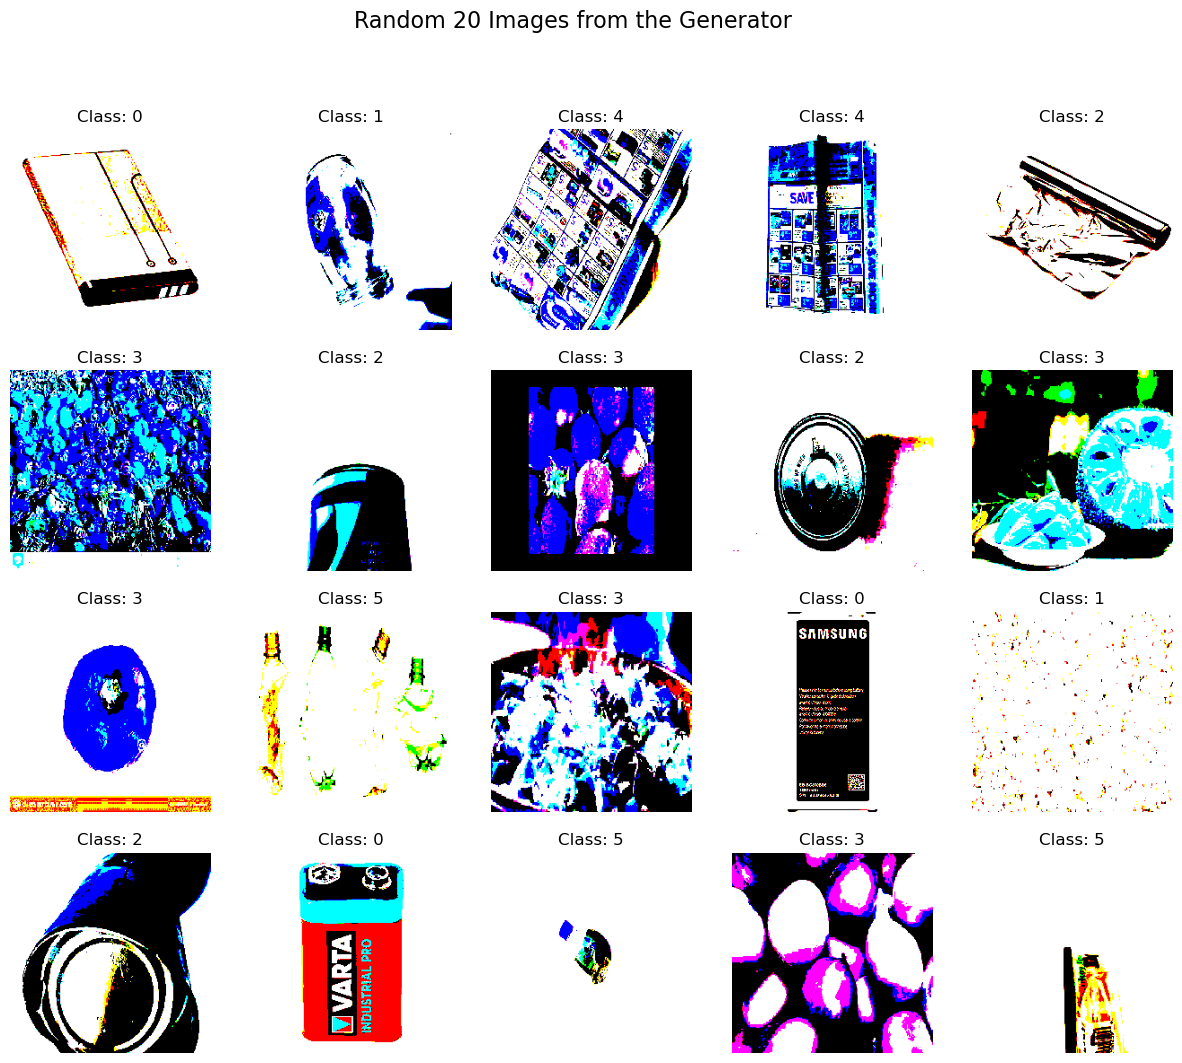

In [17]:
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
full_data = gen_train.flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(full_data)

#### Train Test Split: <a class="anchor" id="subsubsection_4_1_3"></a>
* Before training the model, we divide the data into training and testing sets. Here, the group will split according to the ratio: 90% for the training set, 10% for the test set.

In [18]:
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: str(key) for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(filenames, labels, test_size=0.1, random_state=42)

train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Create separate generators for training and testing using flow_from_dataframe
train_data = gen_train.flow_from_dataframe(train_df, directory=data_path, target_size=(224, 224),
                                           batch_size=BATCH_SIZE, class_mode="categorical",
                                           shuffle=True, seed=42)

test_data = gen_train.flow_from_dataframe(test_df, directory=data_path, target_size=(224, 224),
                                          batch_size=BATCH_SIZE, class_mode="categorical",
                                          shuffle=False)

Found 4185 validated image filenames belonging to 6 classes.
Found 465 validated image filenames belonging to 6 classes.


### Model Training and Validation <a class="anchor" id="subsection_4_2"></a>

During the process of training the model, the team used a number of techniques as follows:
- **Checkpoint:** only saves the best state of the model (with the lowest validation loss).
- **Early Stopping:** Stops if the model does not improve after a certain number of epochs (defined by the patience parameter, we set it here to 15 epochs, after 15 epochs the model does not improve, the training process will stop to avoid wasting resources)
- **Reduce Learning Rate:** Reduce learning rate to avoid overfitting

The team will use 3 different architectures to train the model. Because training models takes time, we have trained our model and uploaded in Drive

- VGG16:

To use each of the above models, the team only needs to save the model into `.h5` files and then upload it for use.

In [19]:
vgg16 = load_model("./Model/model.h5")

In [20]:
output_class = ["battery", "glass", "metal","organic", "paper", "plastic"]

def preprocessing_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) # VGG16 preprocess_input
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path):
    img = preprocessing_input(img_path)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

#### **VGG-16**: <a class="anchor"  id="subsubsection_4_3_1"></a> 

15/15 [==============================] - 49s 1s/step


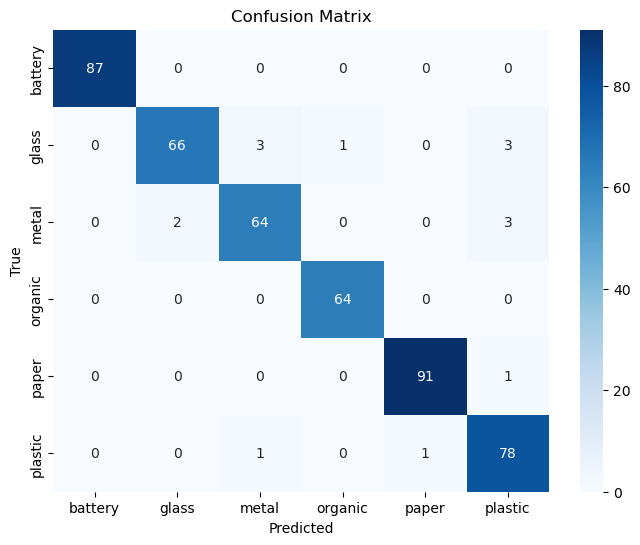

              precision    recall  f1-score   support

     battery       1.00      1.00      1.00        87
       glass       0.97      0.90      0.94        73
       metal       0.94      0.93      0.93        69
     organic       0.98      1.00      0.99        64
       paper       0.99      0.99      0.99        92
     plastic       0.92      0.97      0.95        80

    accuracy                           0.97       465
   macro avg       0.97      0.97      0.97       465
weighted avg       0.97      0.97      0.97       465



In [21]:
predictions = vgg16.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

#### **VGG-19**: <a class="anchor"  id="subsubsection_4_3_2"></a> 

In [22]:
vgg19 = load_model("./Model/model.vgg19.h5")

15/15 [==============================] - 11s 712ms/step


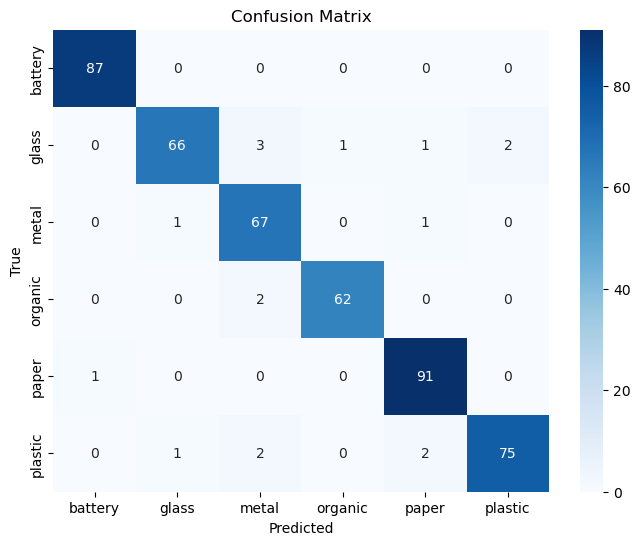

              precision    recall  f1-score   support

     battery       0.99      1.00      0.99        87
       glass       0.97      0.90      0.94        73
       metal       0.91      0.97      0.94        69
     organic       0.98      0.97      0.98        64
       paper       0.96      0.99      0.97        92
     plastic       0.97      0.94      0.96        80

    accuracy                           0.96       465
   macro avg       0.96      0.96      0.96       465
weighted avg       0.96      0.96      0.96       465



In [23]:
predictions = vgg19.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

#### **ResNet50**: <a class="anchor"  id="subsubsection_4_3_3"></a> 

In [24]:
resnet50 = load_model("./Model/model.resnet50.h5")

15/15 [==============================] - 10s 492ms/step


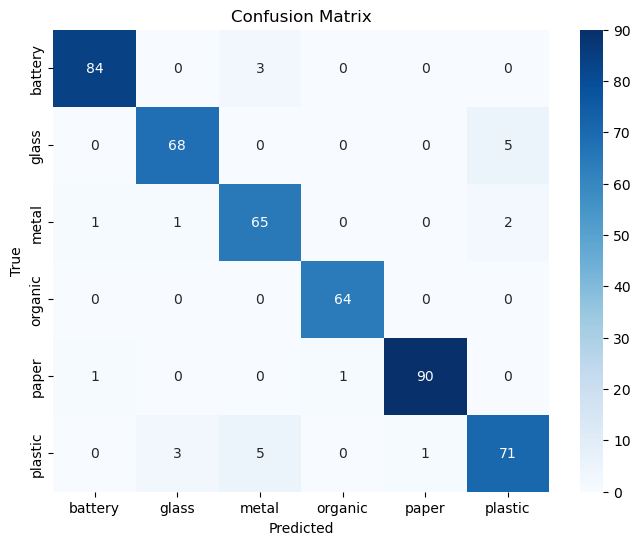

              precision    recall  f1-score   support

     battery       0.98      0.97      0.97        87
       glass       0.94      0.93      0.94        73
       metal       0.89      0.94      0.92        69
     organic       0.98      1.00      0.99        64
       paper       0.99      0.98      0.98        92
     plastic       0.91      0.89      0.90        80

    accuracy                           0.95       465
   macro avg       0.95      0.95      0.95       465
weighted avg       0.95      0.95      0.95       465



In [25]:
predictions = resnet50.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

#### Compare loss and accuracy on the test set for each model <a class="anchor" id="subsubsection_4_3_5"></a>
Finally, to be able to decide which model is the most stable and best for serving API, we compare the loss and accuracy of each model.

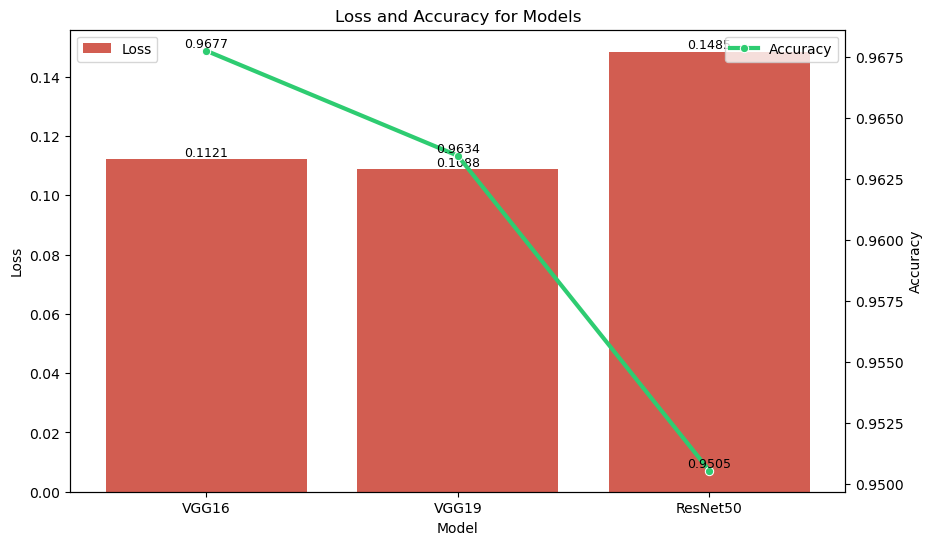

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

models = [vgg16, vgg19, resnet50]
model_names = ['VGG16', 'VGG19', 'ResNet50']

loss_values = []
accuracy_values = []

# Evaluate and store loss/accuracy for each model
for model, name in zip(models, model_names):
    loss, accuracy = model.evaluate_generator(test_data)
    loss_values.append(loss)
    accuracy_values.append(accuracy)

loss_color = '#e74c3c'  
accuracy_color = '#2ecc71'

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=model_names, y=loss_values, color=loss_color, ax=ax1, label='Loss')
ax2 = ax1.twinx()
sns.lineplot(x=model_names, y=accuracy_values, color=accuracy_color, marker='o', ax=ax2, label='Accuracy', linewidth=3) # Ubah nilai linewidth sesuai keinginan Anda
ax1.set_xlabel('Model')
ax1.set_ylabel('Loss', color='black')
ax2.set_ylabel('Accuracy', color='black')
plt.title('Loss and Accuracy for Models')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tambahkan detail angka pada barplot dan lineplot
for index, value in enumerate(loss_values):
    ax1.text(index, value, str(round(value, 4)), ha='center', va='bottom', fontsize=9, color='black')
for index, value in enumerate(accuracy_values):
    ax2.text(index, value, str(round(value, 4)), ha='center', va='bottom', fontsize=9, color='black')

plt.show()

As the results above, the best order of loss and accuracy are:
* Loss: `VGG19` - `VGG16` - `ResNet50`
* Accuracy: `VGG16` > `VGG19` > `ResNet50`

### Choose a model with appropriate capacity/size to serve <a class="anchor" id="subsubsection_4_3_6"></a>
To view and compare the sizes of the models, we write a function to get the sizes based on the link of each file:
  * *Input*: file_path
  * *Output*: size

In [27]:
def get_file_size(file_path):
    if os.path.exists(file_path):
        # Get the size of the file and convert it to MB
        size_in_bytes = os.path.getsize(file_path)
        size_in_mb = size_in_bytes / (1024 * 1024)  # 1 MB = 1024 KB = 1024 * 1024 bytes
        return size_in_mb

In [28]:
size_vgg16 = get_file_size('./Model/model.h5')
size_vgg19 = get_file_size('./Model/model.vgg19.h5')
size_resnet50 = get_file_size('./Model/model.resnet50.h5')

In [29]:
# Path to .h5 files
file_paths = [
    './Model/model.h5',
    './Model/model.vgg19.h5',
    './Model/model.resnet50.h5'
]

# Size of files
file_sizes = [get_file_size(file_path) for file_path in file_paths]

# Names of models
model_names = ['VGG16', 'VGG19', 'ResNet50']
for model, size in zip(model_names, file_sizes):
    print(f"Size (MB) of model {model}: {size:.2f} MB")

Size (MB) of model VGG16: 374.35 MB
Size (MB) of model VGG19: 100.56 MB
Size (MB) of model ResNet50: 97.37 MB


> Although `VGG-16` and `VGG-19` give the best and most stable results, the model sizes are very large (`374.35 MB` and `100.56 MB`). Serving this model into an deployment and uploading it to cloud, requires high cost, resources, and slow processing speed. Therefore, we can use a model that consumes less memory, but remains optimal in accuracy. The accuracy of this model is `0.43%` lower than the `VGG16`.

> Thus, choosing `VGG-19` will be the most optimal in terms of model performance and hardware performance with the `accuracy` = `0.9634` and `Loss` = `0.1089` and `size of model VGG-19` is = `100.56 MB`. 

## Test with New Data

In [30]:
# Load models
vgg16 = load_model("./Model/model.h5")
vgg19 = load_model("./Model/model.vgg19.h5")
resnet50 = load_model("./Model/model.resnet50.h5")

output_class = ["battery", "glass", "metal", "organic", "paper", "plastic"]

def preprocessing_input(img_path, model_name):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    if model_name == 'vgg16':
        img = preprocess_input(img)
    elif model_name == 'vgg19':
        img = preprocess_input(img)
    elif model_name == 'resnet50':
        img = preprocess_input(img)
    
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path, model, model_name):
    img = preprocessing_input(img_path, model_name)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print(f"Using {model_name.upper()} model:")
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


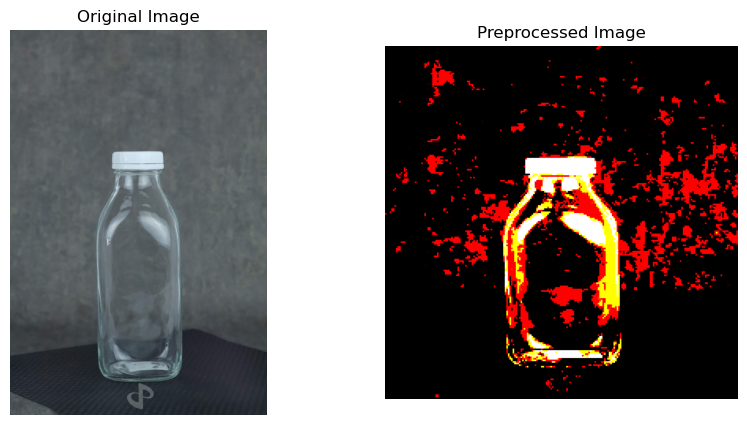

1/1 [==============================] - 0s 58ms/step
Using VGG16 model:
Your waste material is glass with 99.86 % accuracy.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


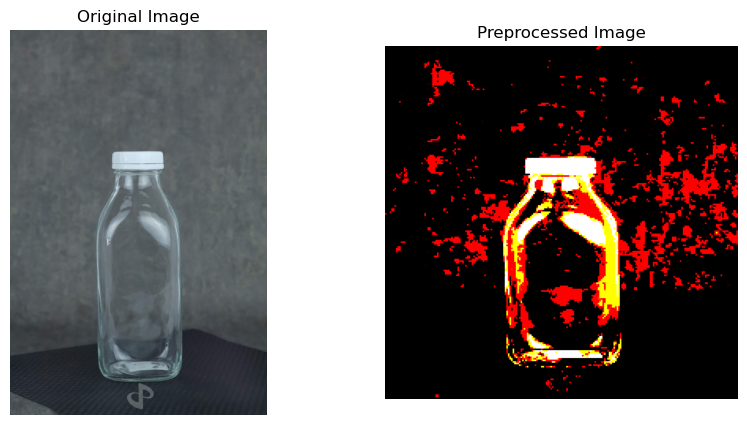

1/1 [==============================] - 0s 66ms/step
Using VGG19 model:
Your waste material is glass with 97.31 % accuracy.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


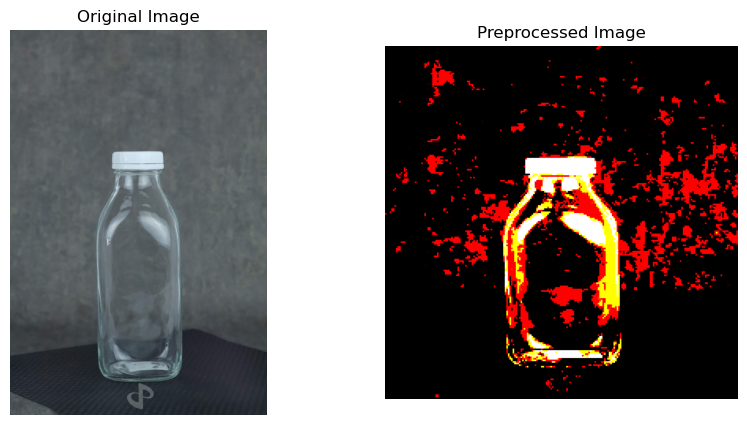

1/1 [==============================] - 0s 64ms/step
Using RESNET50 model:
Your waste material is glass with 74.2 % accuracy.


In [35]:
# Example usage
predict_user("./Model/botolkaca.jpg", vgg16, 'vgg16')
predict_user("./Model/botolkaca.jpg", vgg19, 'vgg19')
predict_user("./Model/botolkaca.jpg", resnet50, 'resnet50')